# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

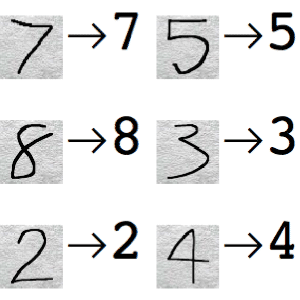

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


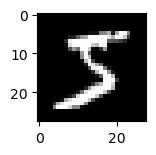

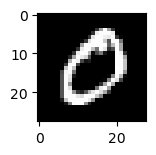

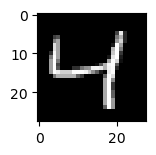

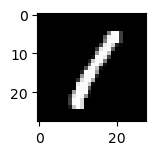

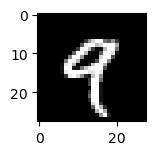

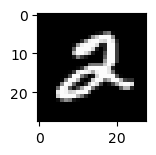

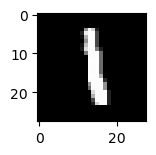

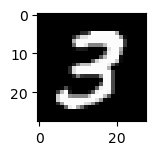

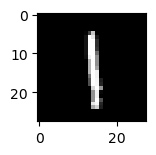

In [1]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [4]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [3]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [4]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [5]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [6]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [7]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [8]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [9]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

> 98.558
> 98.750
> 98.658
> 98.858
> 98.833


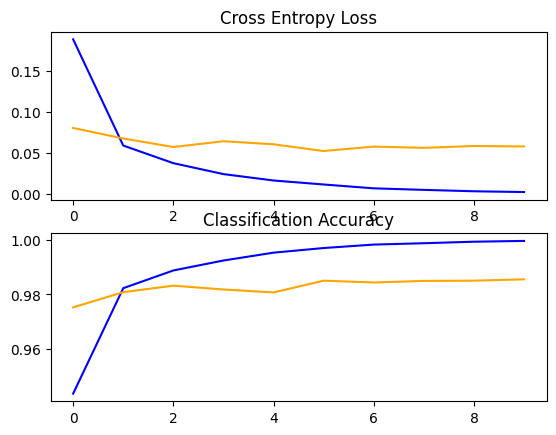

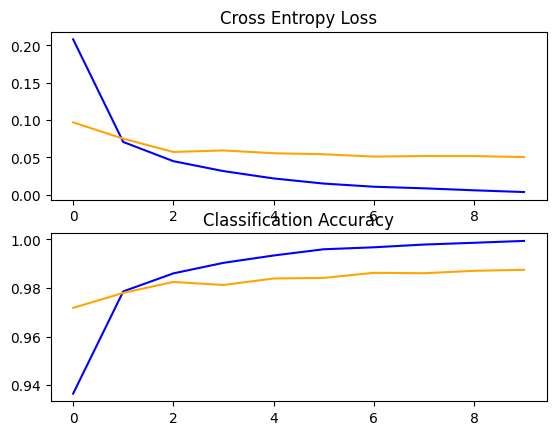

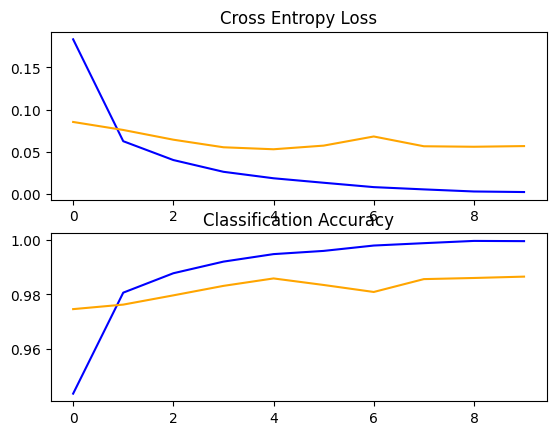

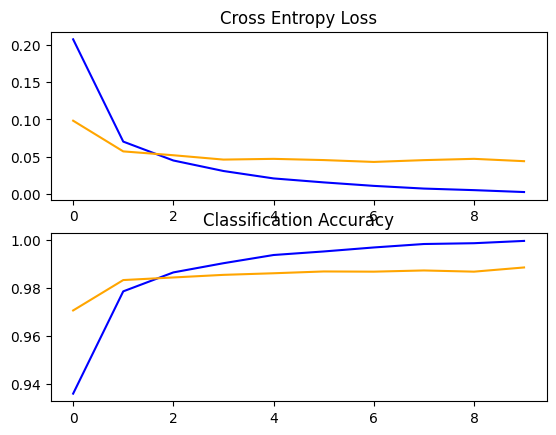

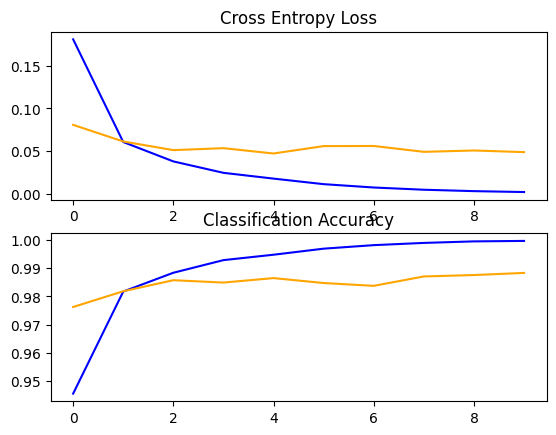

Accuracy: mean=98.732 std=0.111, n=5


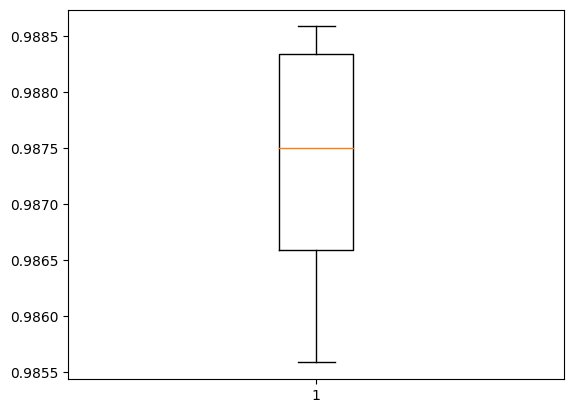

In [ ]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [10]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('final_model.h5')

## Evaluate Final Model

In [11]:
run_test_harness2()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Make Prediction

In [12]:
def load_image(filename):
  # load the image
  img = load_img(filename, grayscale=True, target_size=(28, 28))

  # convert to array
  img = img_to_array(img)

  # reshape into a single sample with 1 channel
  img = img.reshape(1, 28, 28, 1)

  # prepare pixel data
  img = img.astype('float32')
  img = img / 255.0

  return img

In [ ]:
# load an image and predict the class
def run_example(img):
  img = img.reshape(1, 28, 28, 1)
  img = img.astype('float32')

  # Load model
  model = load_model('final_model.h5', compile=False)

  # predict the class
  predict_value = model.predict(img)

  return argmax(predict_value)

# Self

## Import some lib

Imported several libraries to provide more efficient tools

In [20]:
# Requirement
import cv2
import os

## Get path from scatch

In [18]:
def get_imgs_path(folder_path):
  # Object to store imge path
  imgs_path = []

  # Each member in team
  for member in os.listdir(folder_path):
    inner_path = os.path.join(folder_path, member)

    # Each folder of particular digit
    for digit in os.listdir(inner_path):
      deepest_path = os.path.join(inner_path, digit)

      # Each image of current digit
      for filename in os.listdir(deepest_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
          image_path = os.path.join(deepest_path, filename)

          # Information about the origin of an image  
          imgs_path.append((image_path, digit, member))

  return imgs_path

## Load and preprocessing image

- Grayscale (eliminate channel)

In [19]:
def load_img(img_path):
  # Load the image using cv2.imread()
  img = cv2.imread(img_path)

  # Grayscale image
  imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return imgGray

\1.
2. **Load Images and Apply Thresholding:**
   - An empty list `imgs` is created to store the processed images.
   - The code iterates through the list of image paths (`imgs_path`).
     - For each path, `load_img(path[0])` (assumed to be an external function) loads the image.
     - Otsu's thresholding is applied using OpenCV's `cv2.threshold` function with `cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU`. This method automatically determines an optimal threshold to separate foreground (object) from background pixels.
     - The thresholded image is inverted using `cv2.bitwise_not` to convert the foreground to white and background to2.lack.

3. **Resize and Normalize Images:**
   - The inverted image (`inverted`) is resized to a consistent size of (28, 28) using `cv2.resize` with the `cv2.INTER_AREA` interpolation method. This is commonly done for models that expect a fixed input size.
   - The resized image (`img2`) is normalized by dividing each pixel value by 255.0, scaling the range from [0, 255] to [0, 1]. This can improve model performance by making the data more 3.nsistent.

4. **Binarize with Smoothing (Potential Issue):**
   - The code iterates through each pixel in `img2`.
     - If a pixel's value is greater than 0.1, it's incremented by 0.5. This step aims to create a sharper binary image (0 or 1), but the threshold of 0.1 and increment of 0.5 might need adjustment depending on your data.
     - If the pixel value exceeds 1 after the increment, it's set to 1. This ensures all values are within the 0-1 range.

   - **Potential Improvement:** The current binarization approach may not be optimal. Consider using a more robust technique like adaptive thresholding or a fixed threshold value based on the distribution of your data. Explore different methods and evaluate their impact oumed to be provided by `path[2]`)


In [21]:
def preprocessing():
  imgs_path = get_imgs_path('data')

  # Object to store image
  imgs = []
  for path in imgs_path:
    # Load img
    img = load_img(path[0])

    # Chatbot Gemini
    # Apply Otsu's thresholding
    ret, thresh = cv2.threshold(img, 0, 250, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Invert the threshold (foreground becomes white, background black)
    inverted = cv2.bitwise_not(thresh)

    # Make suit form with input form of model
    img2 = cv2.resize(inverted, (28, 28), interpolation=cv2.INTER_AREA)
    img2 = img2 / 255.0
    img2 = 1 - img2[:, :]

    # Boid the digit
    for i in range(img2.shape[0]):
      for j in range(img2.shape[1]):
        if img2[i][j] > 0.1:
          img2[i][j] += 0.5
          if img2[i][j] > 1:
            img2[i][j] = 1

    plt.subplot(221), plt.imshow(img)
    plt.subplot(222), plt.imshow(img2)
    plt.show()

    # Origin image, processed image, path image, ground truth, member
    imgs.append((img, img2, path[0], path[1], path[2]))
  return imgs

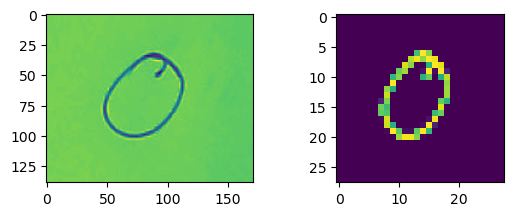

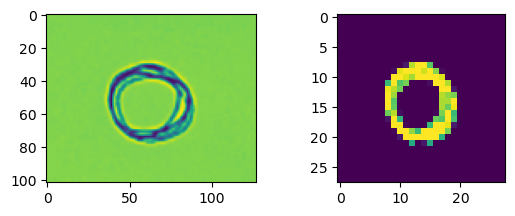

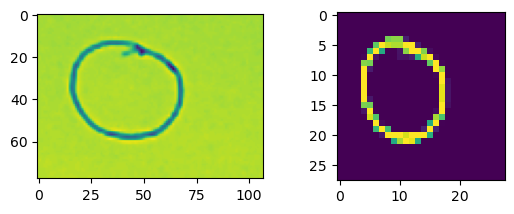

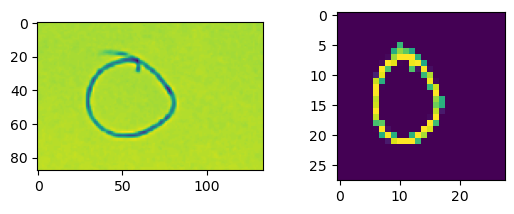

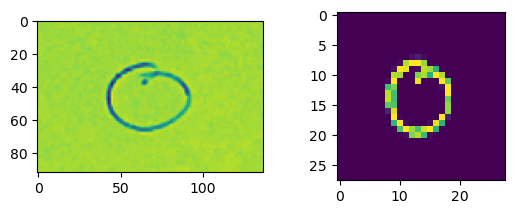

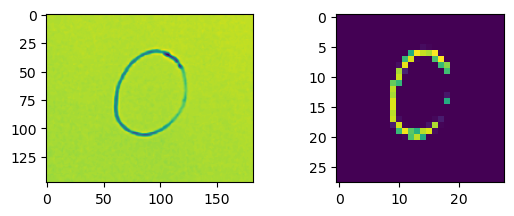

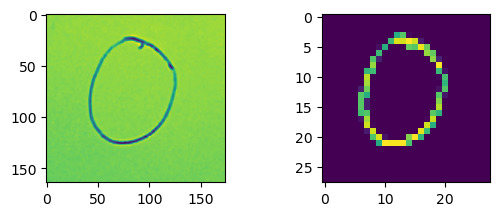

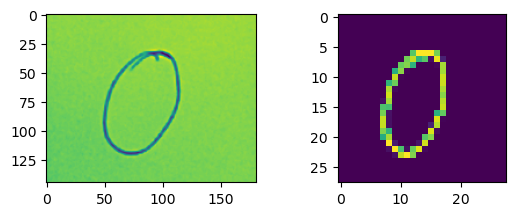

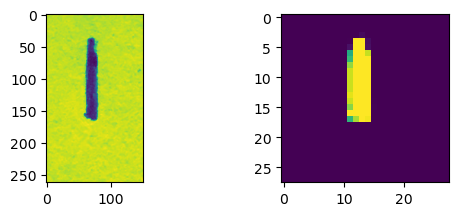

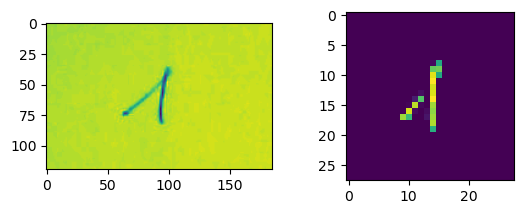

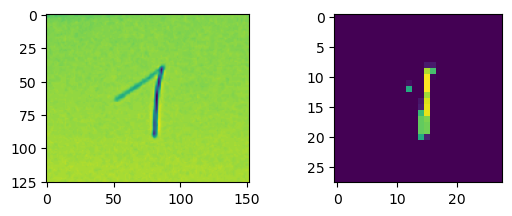

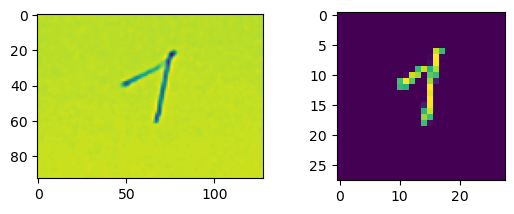

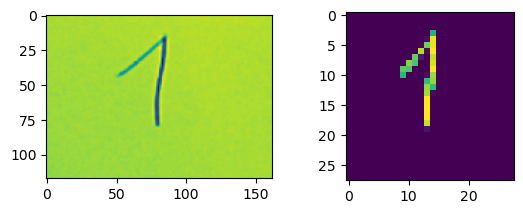

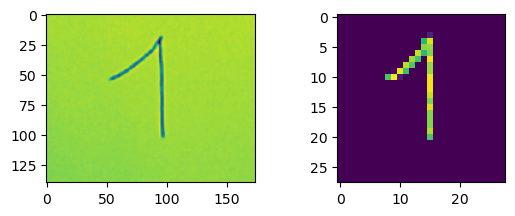

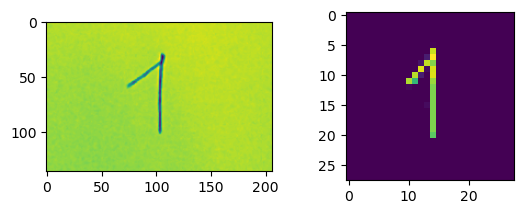

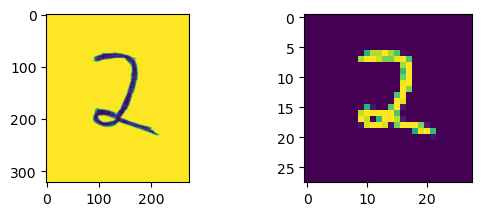

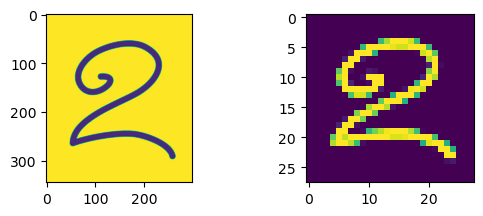

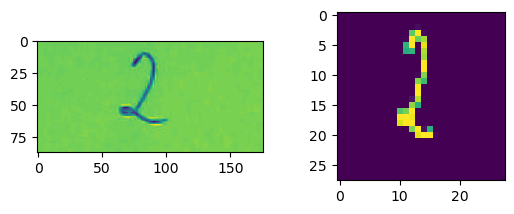

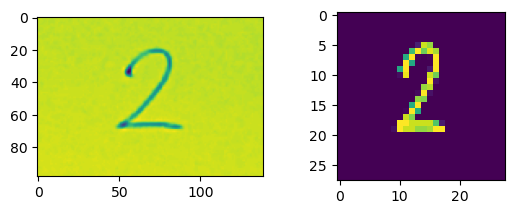

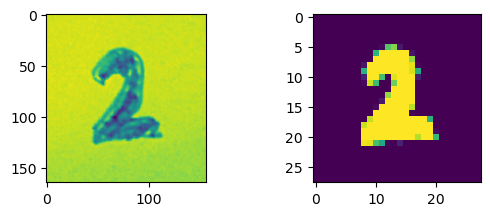

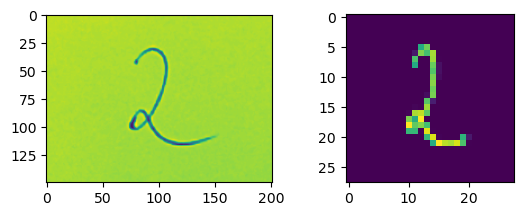

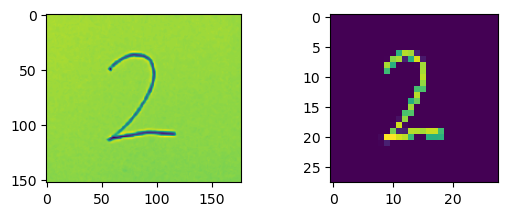

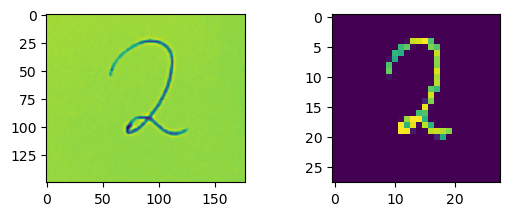

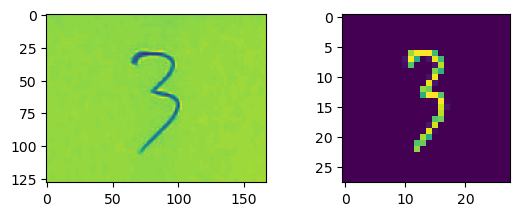

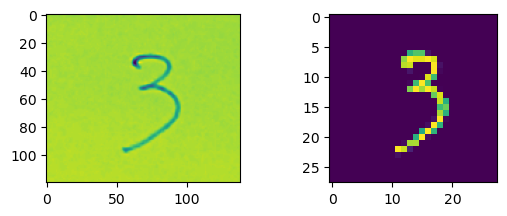

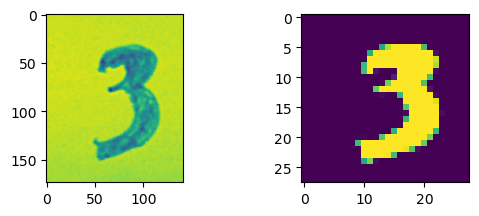

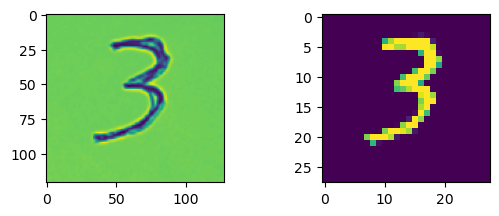

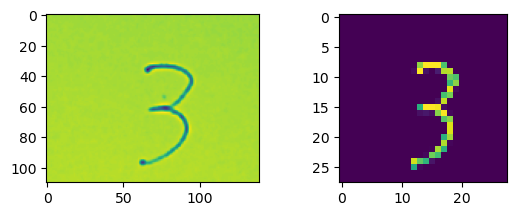

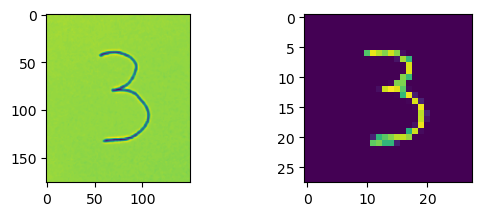

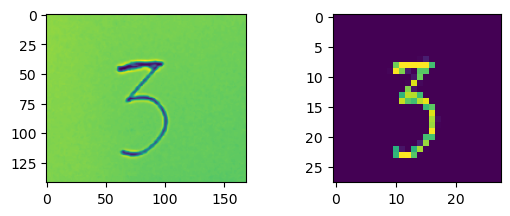

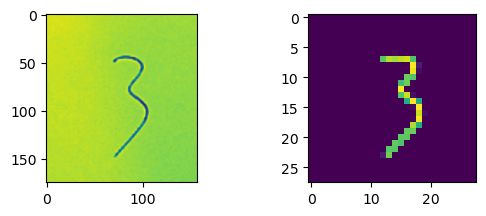

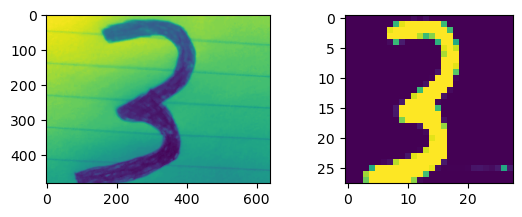

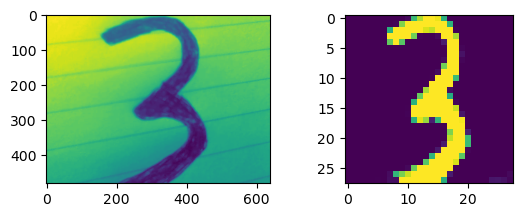

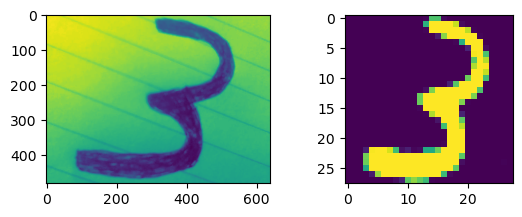

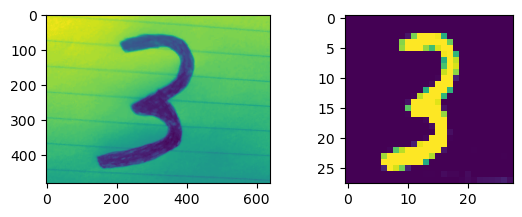

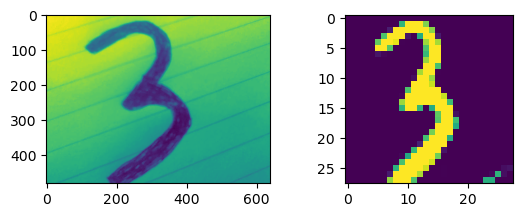

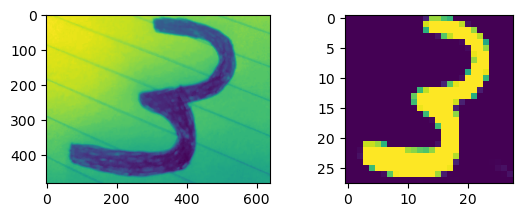

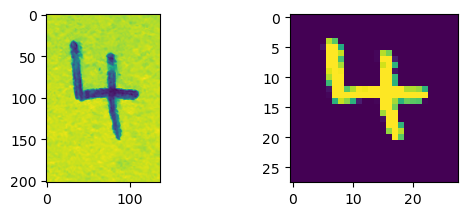

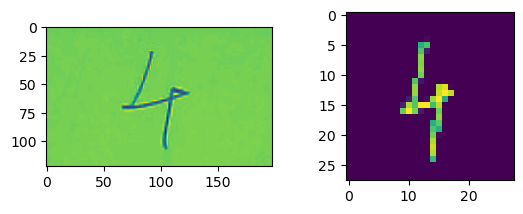

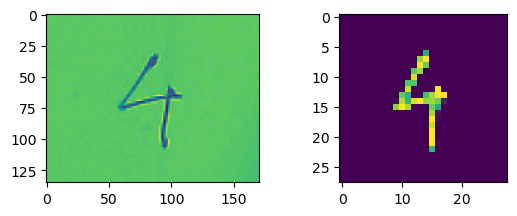

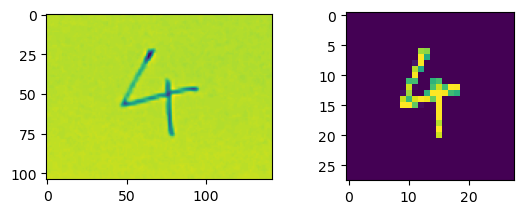

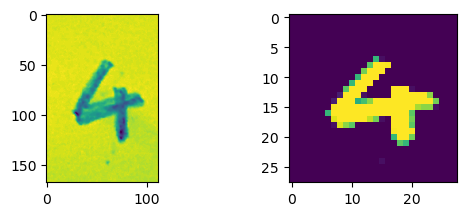

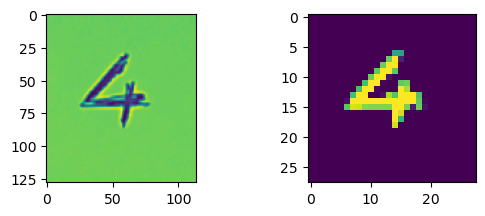

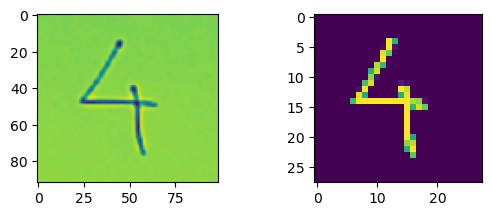

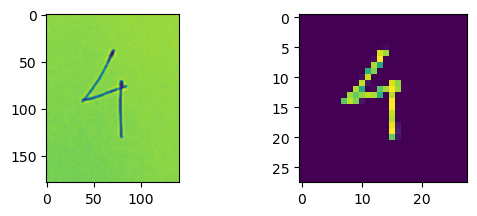

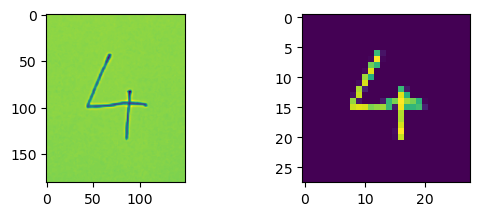

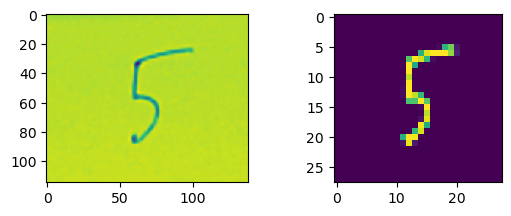

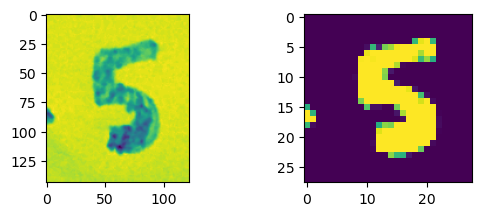

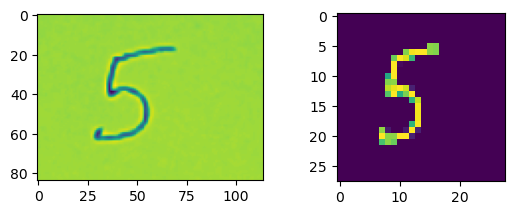

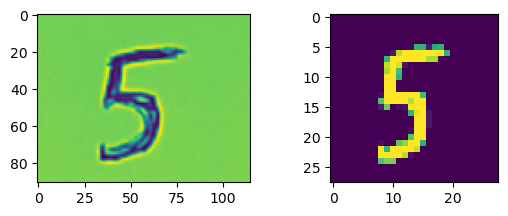

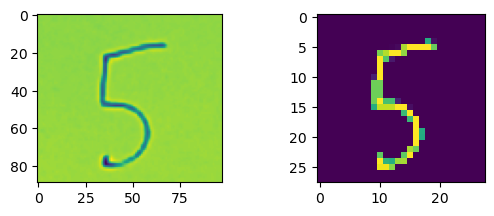

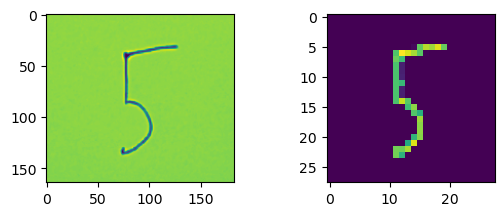

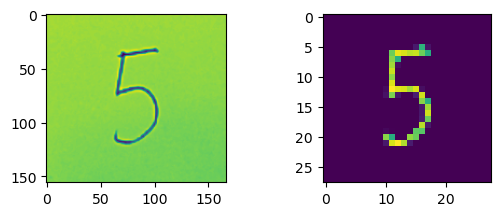

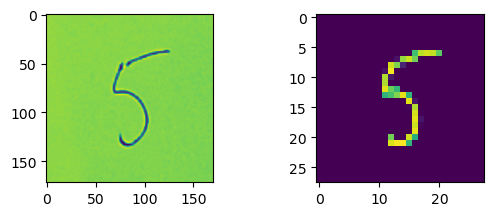

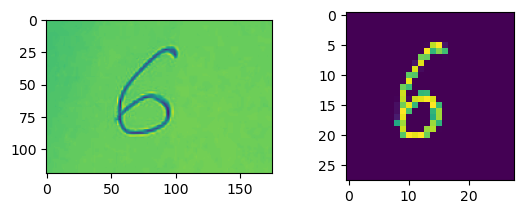

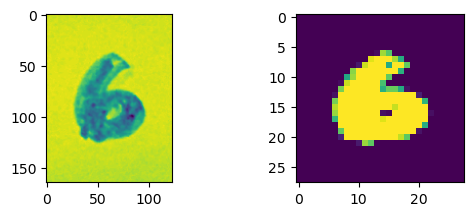

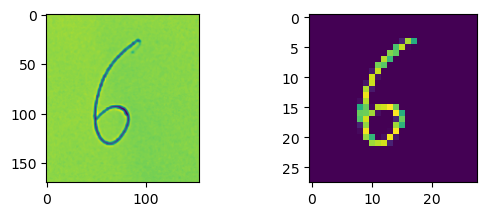

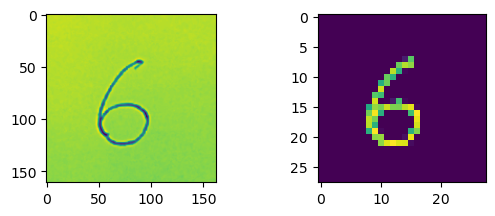

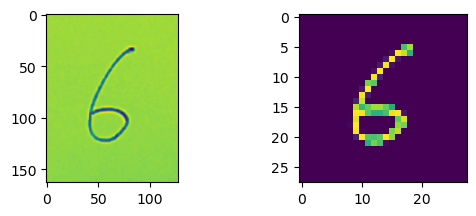

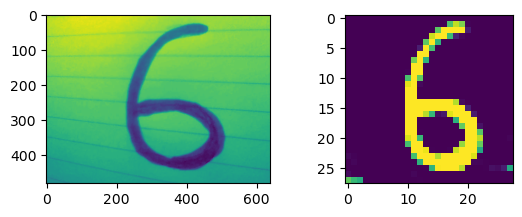

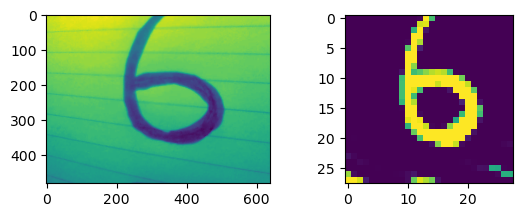

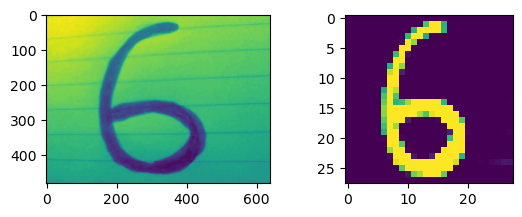

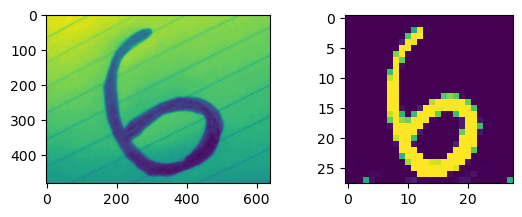

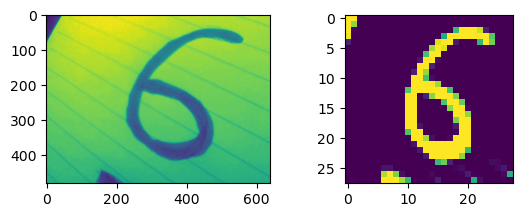

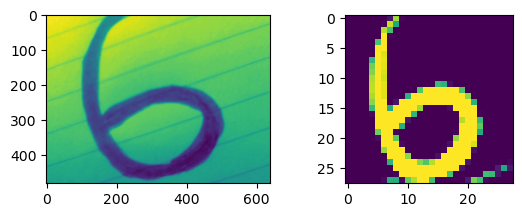

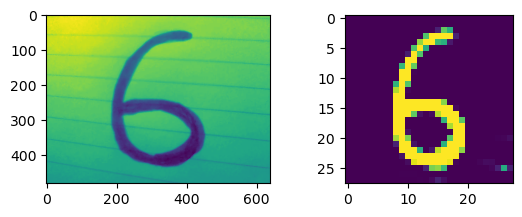

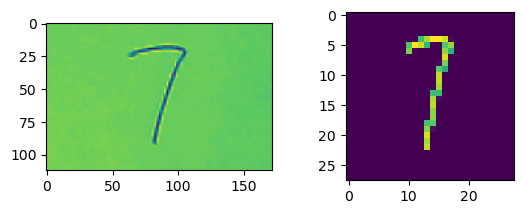

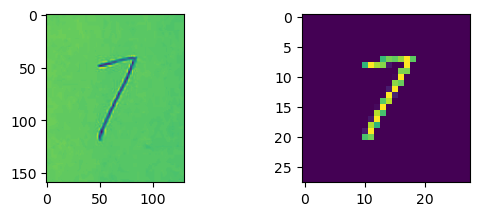

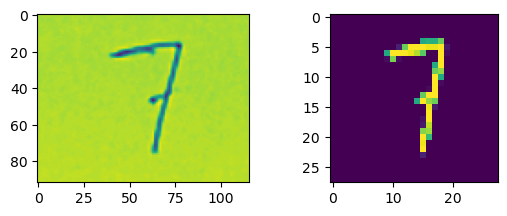

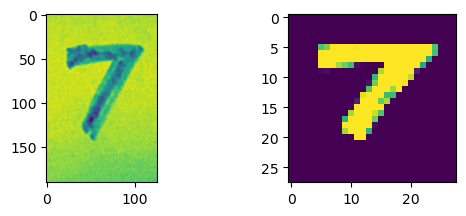

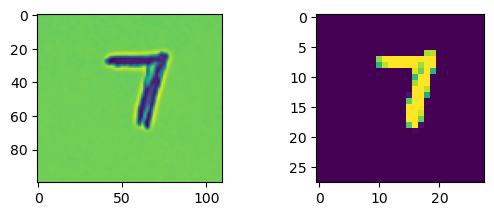

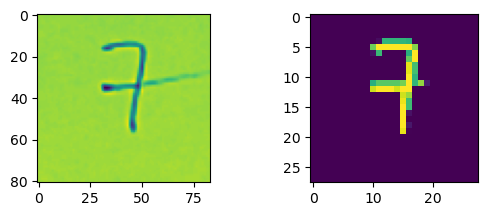

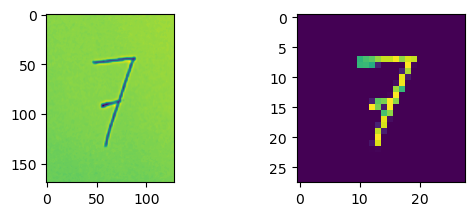

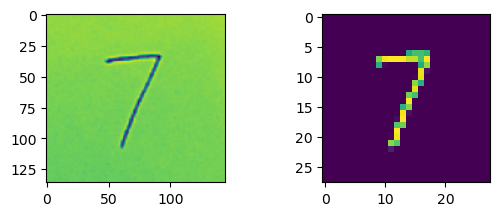

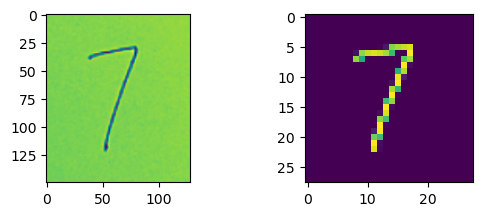

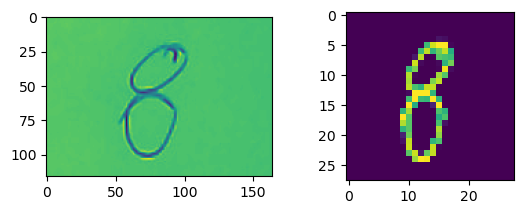

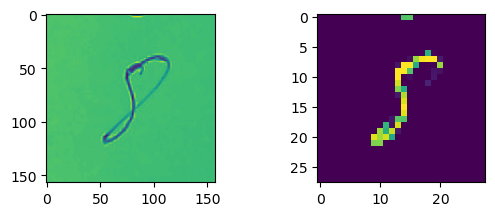

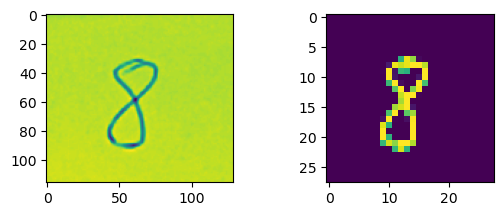

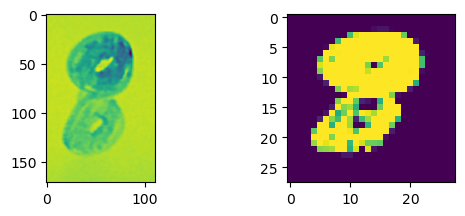

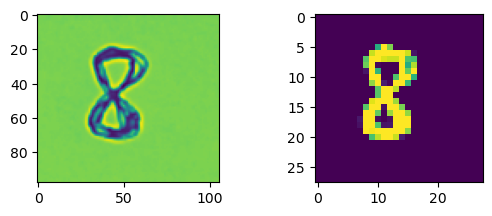

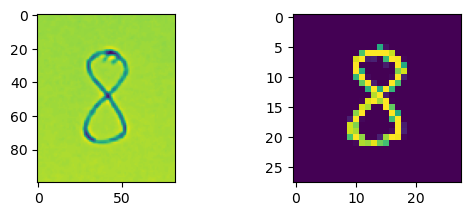

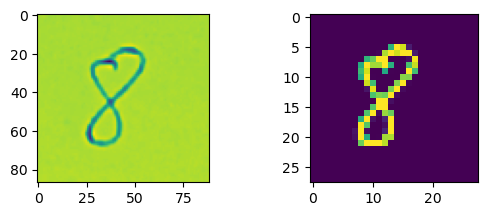

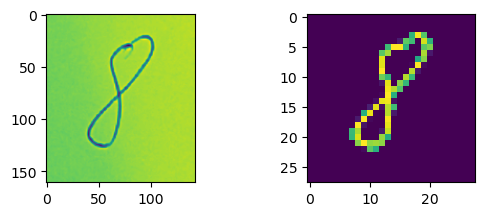

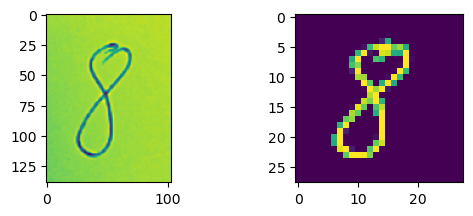

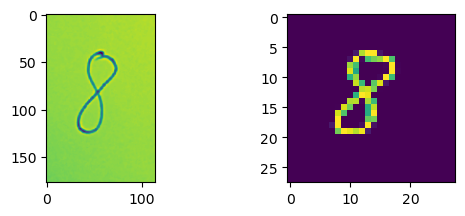

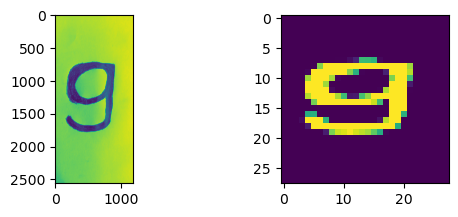

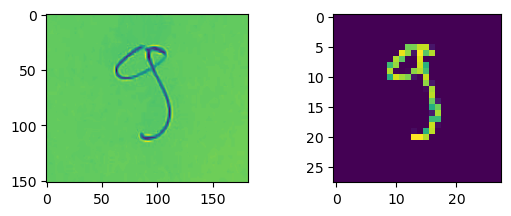

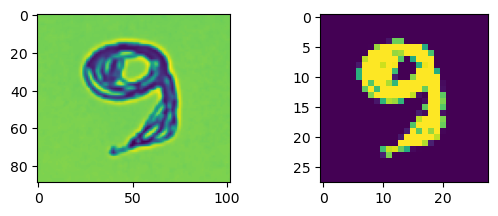

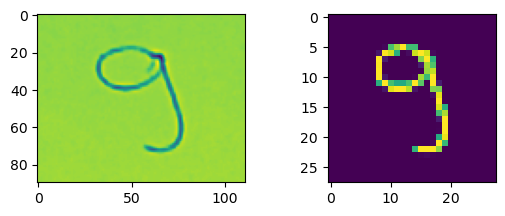

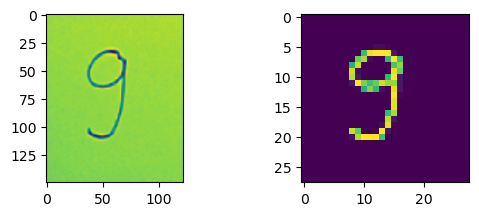

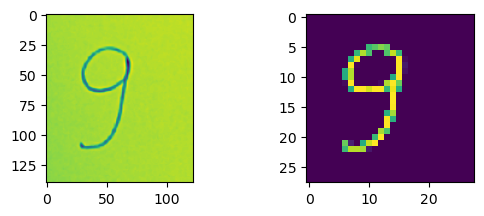

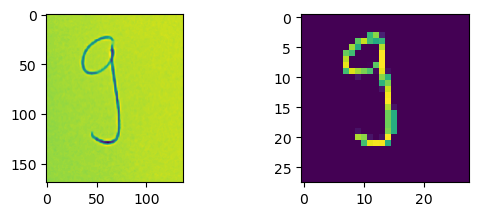

In [11]:
imgs = preprocessing()

1/1 [==============================] - 0s 86ms/step
2
0


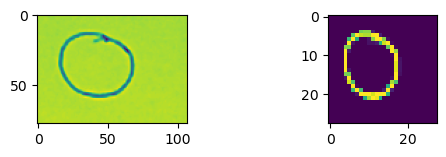

1/1 [==============================] - 0s 59ms/step
9
0


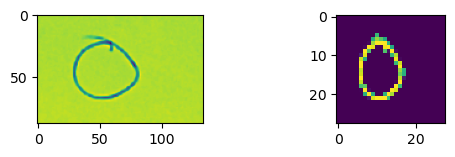

1/1 [==============================] - 0s 94ms/step
9
0


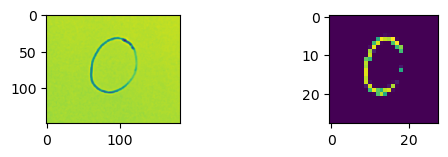

1/1 [==============================] - 0s 59ms/step
9
0


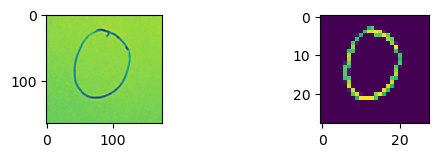

1/1 [==============================] - 0s 86ms/step
9
1


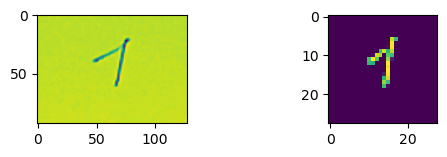

1/1 [==============================] - 0s 81ms/step
8
5


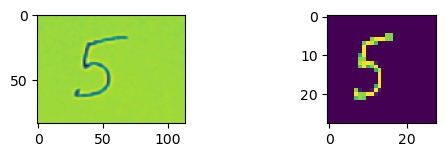

1/1 [==============================] - 0s 90ms/step
9
6


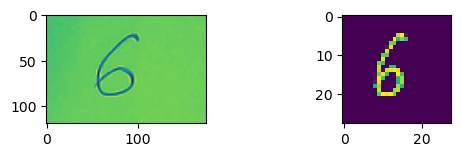

1/1 [==============================] - 0s 84ms/step
9
6


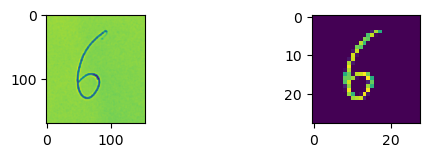

1/1 [==============================] - 0s 88ms/step
1
7


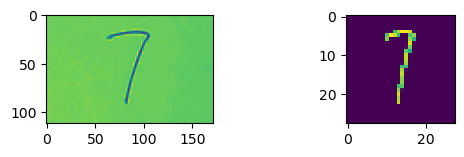

1/1 [==============================] - 0s 103ms/step
9
7


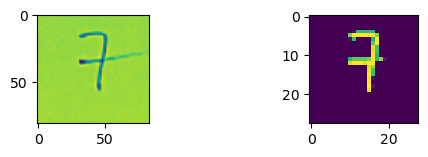

1/1 [==============================] - 0s 88ms/step
9
8


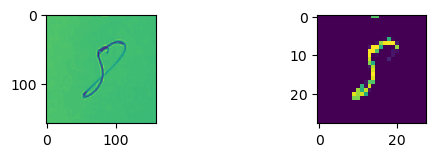

1/1 [==============================] - 0s 81ms/step
2
8


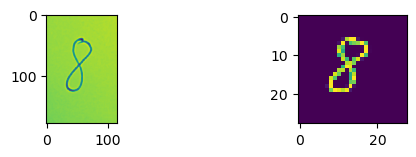

1/1 [==============================] - 0s 82ms/step
3
9


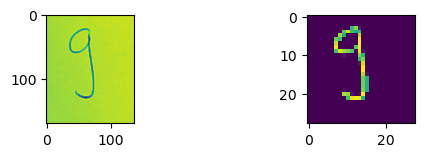

0.8586956521739131


In [17]:
count = 0
for img in imgs:
  # entry point, run the example
  predict = run_example(img[1])
  if f'{predict}' == img[3]:
    count += 1
  else:
    print(f'Predict {predict}')
    print(f'Ground Truth {img[3]}')
    plt.subplot(321), plt.imshow(img[0])
    plt.subplot(322), plt.imshow(img[1])
    plt.show()

print(count / len(imgs))